## Objetivo

El dataset fue extraído de [Kaggle](https://www.kaggle.com/code/nathanoliver/spain-electricity-price-prediction/input).
El mismo contiene dos archivos:
- **datasets/energy_dataset.csv**; el cual contiene registros históricos sobre:
    - Los precios de electricidad en España, medido en Euros por mega watt hora [€/MWh]. 
    - La generación de electricidad, medida por tipo de orígen (carbón, gas, viento, etc).
    - Demanda histórica de energía.
- **datasets/weather_features.csv**; el cual contiene registros históricos sobre:
    - Temperatura, presión, humedad, viento, lluvia, etc. En distintas ciudades de España.

El objetivo será predecir los precios futuros de la energía (**lag 1**).

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pickle
import os

from pprint import pprint
from copy import deepcopy
from collections import Counter
from collections.abc import Iterable
import holidays

# Data cleaning
from itba_ml.data_processing.data_cleaner import DataCleaner

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# Feature Selectionb
from boruta import BorutaPy
import tsfresh as tsf

# Sklearn
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

# Non-deep learning ML models
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.config.experimental import list_physical_devices
from tensorflow.keras.optimizers import Adam

# Hyper-parameter tunning
from hyperopt import fmin, hp, tpe, STATUS_OK
from hyperopt.fmin import generate_trials_to_calculate
from hyperopt.pyll.base import scope

# Logging
from itba_ml.utils.logging_helper import get_logger

import warnings
warnings.filterwarnings("ignore")

In [2]:
LOGGER = get_logger(
    name=__name__,
    level='DEBUG'
)

In [3]:
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

## Explanatory Data Analysis

### Data Loading

In [4]:
# Energy Dataset
energy_path = os.path.join("..", "datasets", "energy_dataset.csv")
energy_df = pd.read_csv(energy_path, header=0, parse_dates=["time"])

# Weather Features
weather_path = os.path.join("..", "datasets", "weather_features.csv")
weather_df = pd.read_csv(weather_path, header=0, parse_dates=["dt_iso"])

### Energy Data - Data Analysis & Data Cleaning

In [5]:
# Prepare idx
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
energy_df.set_index('time', inplace=True)

#### Basic Characteristics

In [6]:
energy_df.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 02:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 03:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [7]:
energy_df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [8]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00 to 2018-12-31 22:00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil coal-derived gas           35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation fossil oil shale                  35046 non-null  float64
 7   generation fossil peat                       35046 non-null  float64
 8   generation geothermal                        35046 non-null  float64
 9   generation hydro pumped storage aggre

#### Missing Values
- We observe two empty feature columns. On the right-hand side, we notice a few gaps in individual rows of the other columns.

<Axes: >

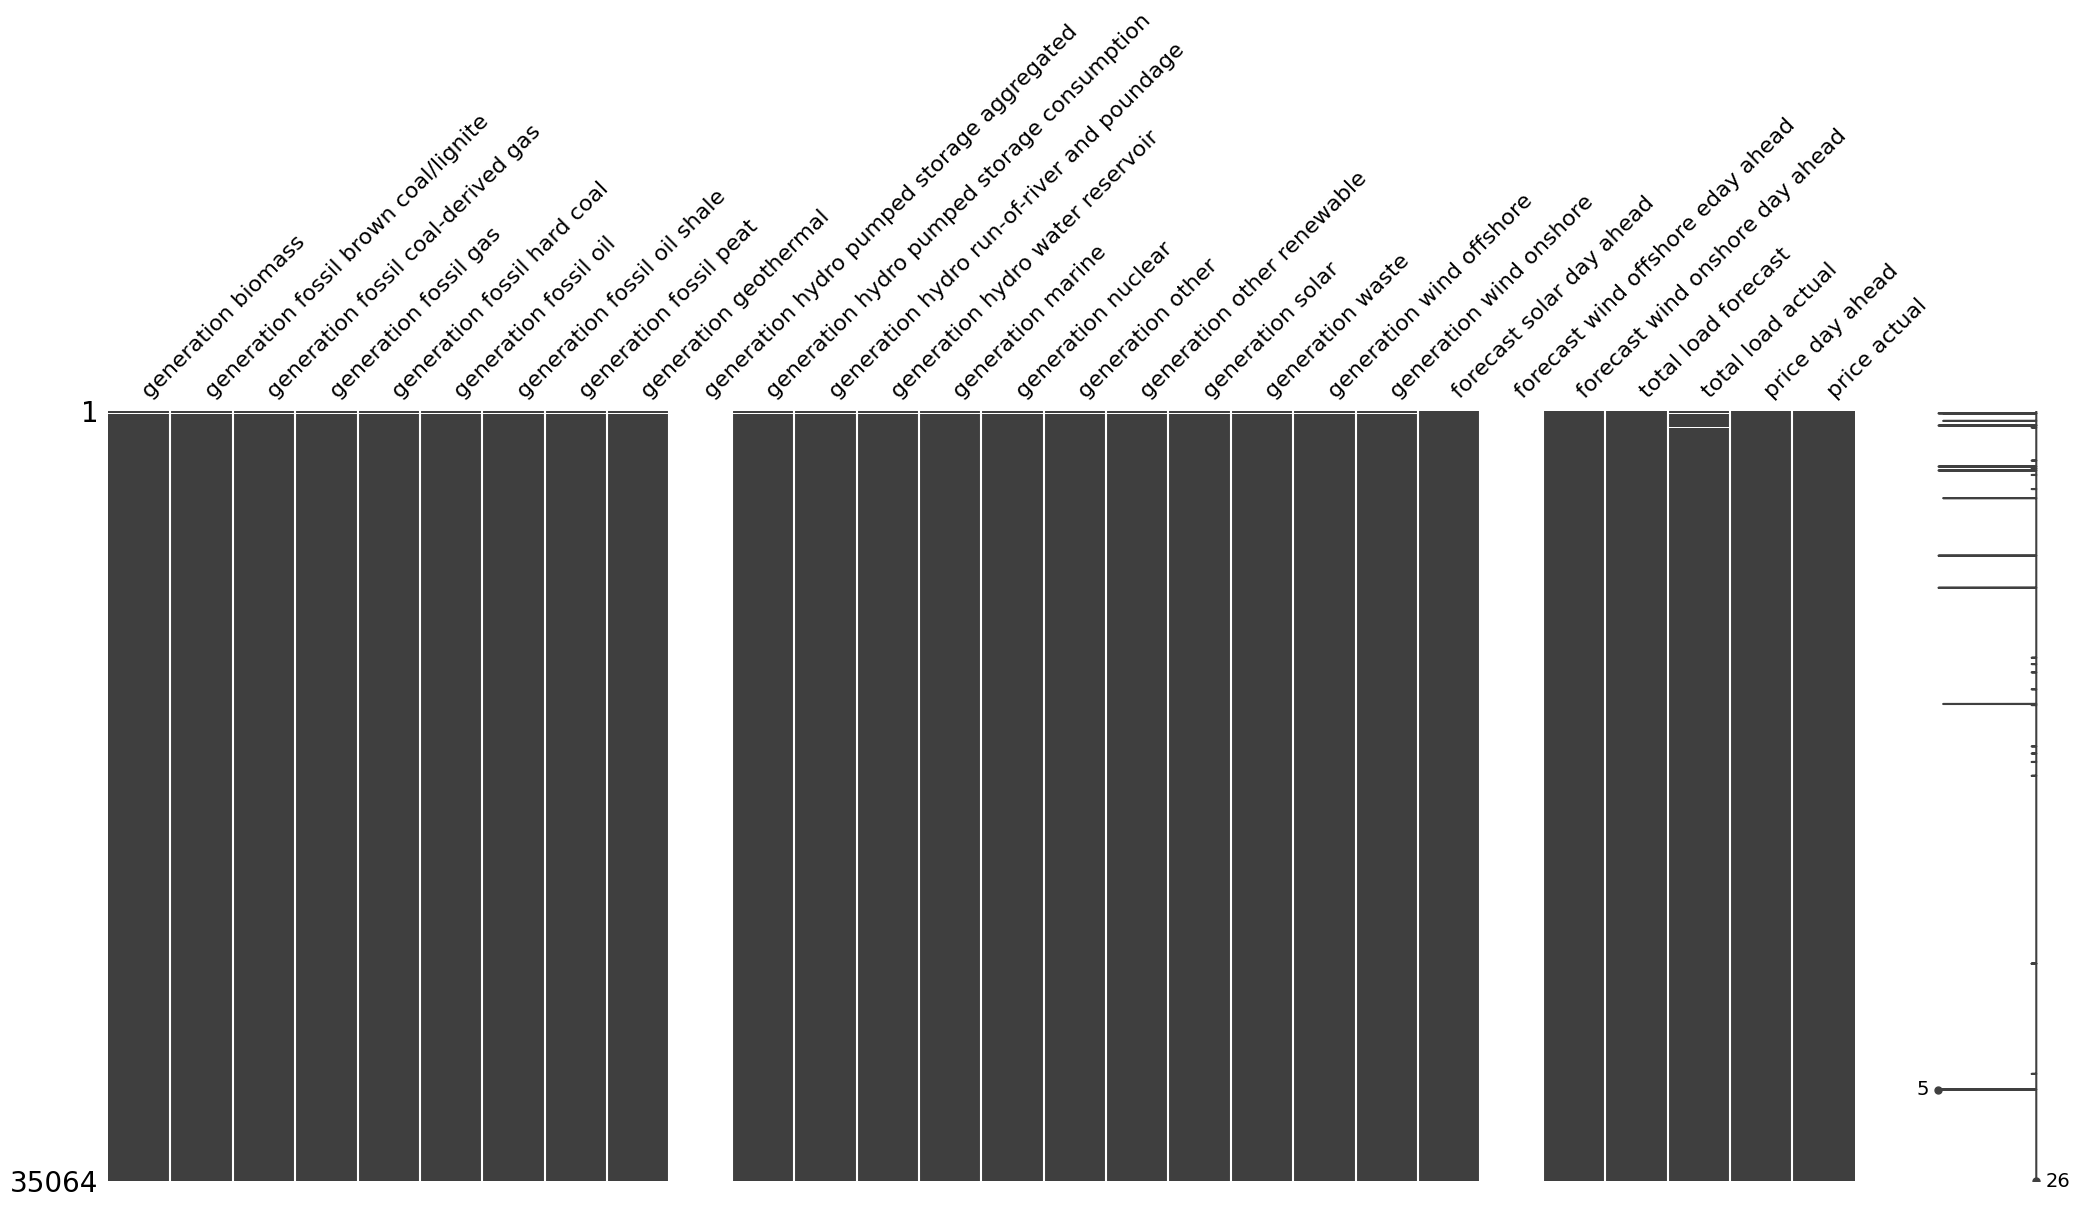

In [9]:
msno.matrix(energy_df)

### Data Cleaning

In [10]:
DC = DataCleaner(df=energy_df)

In [11]:
# Drop columns with:
#   - All null values
#   - All 0 values
#   - Drop forecast columns

DC.drop_unuseful_columns(
    drop_columns=energy_df.filter(regex="forecast").columns
)

In [12]:
# Fill null values:
#   - interpolating numerical columns
#   - filling categorical columns with mode

DC.fill_null_values(method='interpolate')

In [13]:
# Rename columns
rename_dict = {
    'generation biomass': 'gen_bio', 
    'generation fossil brown coal/lignite': 'gen_lig', 
    'generation fossil coal-derived gas': 'gen_coal_gas', 
    'generation fossil gas': 'gen_gas', 
    'generation fossil hard coal': 'gen_coal', 
    'generation fossil oil': 'gen_oil', 
    'generation fossil oil shale': 'gen_oil_shale', 
    'generation fossil peat': 'gen_peat', 
    'generation geothermal': 'gen_geo', 
    'generation hydro pumped storage consumption': 'gen_hyd_pump', 
    'generation hydro run-of-river and poundage': 'gen_hyd_river', 
    'generation hydro water reservoir': 'gen_hyd_res', 
    'generation marine': 'gen_mar', 
    'generation nuclear': 'gen_nuc', 
    'generation other': 'gen_other', 
    'generation other renewable': 'gen_oth_renew', 
    'generation solar': 'gen_sol', 
    'generation waste': 'gen_waste', 
    'generation wind offshore': 'gen_wind_off', 
    'generation wind onshore': 'gen_wind_on', 
    'total load actual': 'load_actual', 
    'price day ahead': 'price_dayahead', 
    'price actual': 'price'
}

DC.rename_columns(rename_dict=rename_dict)

In [15]:
# Drop duplicates:
#   - Duplicate idxs
#   - Duplicated columns

DC.remove_duplicates()

# Show duplicated idxs
LOGGER.info("Duplicated idxs: %s", DC.df.loc[DC.df.index.duplicated()].shape[0])

__main__: 2024-05-05 13:27:48,484 | INFO | 3171496937.py:8 | Duplicated idxs: 0


In [ ]:
# Remove outliers
#   - Remove that values are over 2.5 stds from the mean

DC.drop_outliers()

# Show max values
LOGGER.info("Duplicated idxs: %s", DC.df.loc[DC.df.index.duplicated()].shape[0])

#### Extreme values

In [ ]:
# Calculate the absolute z_scores
z_scores = np.abs(st.zscore(energy_df))

In [ ]:
z_scores.head()

In [ ]:
# Remove values where z_score is over 2.5 stdev
for col in energy_df.columns:
    energy_df.loc[z_scores[col] > 2.5] = np.nan

In [ ]:
# Replace outliers with mean/median values for that column
means_dict = {col: energy_df[col].median() for col in energy_df.columns}

In [ ]:
energy_df.fillna(value=means_dict, inplace=True)

In [ ]:
energy_df.describe()

### Target Anlysis
- A lineplot of the hourly prices shows that the curve that does not appear to follow a stable long-term trend or a single seasonality pattern, but fluctuates around a mean price of €60. 
- Since we deal with hourly prices, there might also be seasonalities related to **hours**, **weekdays** & **months**

In [ ]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(
    x="time", 
    y="price", 
    data=energy_df, 
    palette="coolwarm"
)

#### Auto-Correlations & Partial Auto-Correlations
- Both plots show statistically significant AC values and PAC values
- This indicates that the data is autocorrelated, which could imply that there are some seasonality effects.

In [ ]:
plt.figure(100, figsize=(20, 7))
plot_acf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

In [ ]:
plot_pacf(energy_df['price'], lags=20, alpha=0.05)
plt.show()

#### Seasonal decomposition
- Decomposing the time series with both **weekly** and **monthly** frequencies portray a decisive seasonality component for the time series.

In [ ]:
# Define data to plot
last_year = energy_df.loc[energy_df.index > '2018', 'price']

In [ ]:
# Plot Weekly frequency
decomp = seasonal_decompose(last_year, period=24*7)

decomp.plot()
plt.show()

In [ ]:
# Plot Monthly frequency
decomp = seasonal_decompose(last_year, period=24*30)

decomp.plot()
plt.show()

### Weather Data - Data Analysis & Data Cleaning

In [ ]:
# Prepare idx
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True, infer_datetime_format=True).dt.tz_localize(None)
weather_df.set_index('dt_iso', inplace=True)

#### Basic Characteristics

In [ ]:
weather_df.head()

In [ ]:
weather_df.city_name.unique()

In [ ]:
weather_df.describe()

In [ ]:
weather_df.info()

#### Missing Values
- No missing values were found

In [ ]:
msno.matrix(weather_df)

In [ ]:
# Drop columns with all values equal to 0
weather_df = weather_df.loc[:, (weather_df!=0).any(axis=0)]

#### Manage Columns

In [ ]:
# drop unnecessary columns
drop_cols = ["rain_3h", "weather_id", "weather_main", "weather_description", "weather_icon"]
weather_df.drop(drop_cols, inplace=True, axis=1, errors="ignore")

#### Basic Transformations

In [ ]:
# temperature: kelvin to celsius
temp_cols = [col for col in weather_df.columns if "temp" in col]
weather_df[temp_cols] = weather_df[temp_cols].filter(like="temp").applymap(lambda t: t - 273.15)

In [ ]:
# convert int and float64 columns to float32
intcols = list(weather_df.dtypes[weather_df.dtypes == np.int64].index)
weather_df[intcols] = weather_df[intcols].applymap(np.float32)

f64cols = list(weather_df.dtypes[weather_df.dtypes == np.float64].index)
weather_df[f64cols] = weather_df[f64cols].applymap(np.float32)

f32cols = list(weather_df.dtypes[weather_df.dtypes == np.float32].index)

In [ ]:
weather_df.info()

#### Duplicates

In [ ]:
# Remove duplicated rows
weather_df = (
    weather_df
    .reset_index()
    .drop_duplicates(subset=["dt_iso", "city_name"], keep="first")
    .set_index('dt_iso')
)

In [ ]:
# Remove duplicated columns
weather_df = weather_df.loc[:, ~weather_df.columns.duplicated(keep='first')]

#### Re-group DataFrames

In [ ]:
gb_df = weather_df.groupby("city_name")

In [ ]:
def format_df(df: pd.DataFrame, city: str):
    df.drop(columns=['city_name'], inplace=True)
    return df.add_suffix(f"_{city.replace(' ', '')}")

concat_weather_df = pd.concat(
    [format_df(gb_df.get_group(city), city) for city in gb_df.groups.keys()],
    axis=1
).interpolate()

In [ ]:
concat_weather_df.head()

#### Extreme values

In [ ]:
# Calculate the absolute z_scores
num_cols = list(concat_weather_df.select_dtypes(include=['number']).columns)
z_scores = np.abs(st.zscore(concat_weather_df[num_cols]))

In [ ]:
z_scores.head()

In [ ]:
# Remove values where z_score is over 2.5 stdev
for col in num_cols:
    concat_weather_df.loc[z_scores[col] > 2.5] = np.nan

In [ ]:
# Replace outliers with mean values for that column
means_dict = {col: concat_weather_df[col].mean() for col in num_cols}

In [ ]:
concat_weather_df.fillna(value=means_dict, inplace=True)

In [ ]:
concat_weather_df.describe()

### Merge DataFrames

In [ ]:
# Energy & Weather Concat
df = pd.concat([energy_df, concat_weather_df], axis=1)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.describe()

Define ***Target***

In [ ]:
y = df['price']

Define ***Features***
- Features will be *lagged* one observation, as we will be forecasting *one period ahead*

In [ ]:
X_forecast = pd.DataFrame(
    index=df.index[-1:] + pd.Timedelta(minutes=60),
    columns=df.columns.tolist()
)

In [ ]:
X = (
    pd.concat([df, X_forecast])
    .shift(1)
    .fillna(method='bfill')
    .rename(columns={'price': 'lagged_price'})
)

In [ ]:
X.shape

In [ ]:
pd.concat([y, X[['lagged_price']]], axis=1)

# Feature Engineering

### Features Analysis

In [ ]:
# Feature Correlations
df_corr = pd.concat([y, X.loc[X.index.isin(y.index)]], axis=1).corr(method="pearson")

In [ ]:
# Find threshold for features filtering
thresh = np.max([np.quantile(np.abs(df_corr['price'].dropna()), 0.25), 0.1])

In [ ]:
thresh

In [ ]:
# Pick top features and filter df_corr
top_candidates = list(df_corr.loc[np.abs(df_corr['price']).sort_values() > thresh].index)

In [ ]:
len(top_candidates)

In [ ]:
df_corr = (
    df_corr
    .loc[top_candidates, top_candidates]
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

In [ ]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, 
    cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [ ]:
# Plot features distributions
X = X.filter(top_candidates)

rows = int(np.ceil(X.shape[1] / 4))
f, ax = plt.subplots(rows, 4, figsize=(20, rows*4.5), gridspec_kw={'wspace':0.5,'hspace':0.3})

ax = ax.ravel()

for i, col in enumerate(X):
    sns.histplot(X[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=X[col].mean(), color='k', label='mean')
    ax[i].axvline(x=X[col].median(), color='r', label='median')
    
ax[0].legend();
ax[-2].axis('off')
ax[-1].axis('off');

### Feature Enrichment
- There are multiple strategies for enriching features to boost the achievable forecast accuracy of a model.
- This might include techniques like binning, linear combinations of some key features, laggin features, calculating moving average, exponential moing averages, etc.

In [ ]:
def find_optimal_seasonal_period(time_series, max_period=None):
    if max_period is None:
        max_period = len(time_series) // 2

    # Perform seasonal decomposition using STL
    decomposition = seasonal_decompose(time_series, period=max_period)

    # Get the seasonal component
    seasonal_component = decomposition.seasonal.dropna()

    # Compute the periodogram
    n = len(seasonal_component)
    fft_values = np.abs(np.fft.fft(seasonal_component)) ** 2
    fft_values = fft_values[:n // 2]
    frequencies = np.fft.fftfreq(n, 1)
    frequencies = frequencies[:n // 2]

    # Find the index of the maximum frequency
    max_index = np.argmax(fft_values)
    # pprint(fft_values)

    # Calculate the optimal seasonal period
    optimal_period = int(1 / frequencies[max_index])

    # Plot the periodogram (optional)
    plt.plot(1 / frequencies, fft_values)
    plt.xlabel('Seasonal Period')
    plt.ylabel('Periodogram')
    plt.title('Periodogram of Seasonal Component')
    plt.show()

    return optimal_period

In [ ]:
sp = find_optimal_seasonal_period(y.copy(), 24*3*30)

In [ ]:
sp

In [ ]:
lag_periods = list(range(1, sp//2 + 1)) + [sp * i for i in range(1, sp//2 + 1)] + [24*31, 24*365]
rolling_windows = [sp//2, sp, 2*sp]

In [ ]:
lag_periods

In [ ]:
rolling_windows

In [ ]:
# Lagg Features
def lag_df(df_: pd.DataFrame, lag: int):
    df_[df_.columns] = df_[df_.columns].shift(lag, axis=0)
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_lag_{lag}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Simple rolling features
def rolling_df(df_: pd.DataFrame, window: int, agg_fun: str = 'mean'):
    if agg_fun == 'mean':
        df_[df_.columns] = df_.rolling(window=window).mean()
    elif agg_fun == 'std':
        df_[df_.columns] = df_.rolling(window=window).std()
    elif agg_fun == 'max':
        df_[df_.columns] = df_.rolling(window=window).max()
    elif agg_fun == 'min':
        df_[df_.columns] = df_.rolling(window=window).min()
    elif agg_fun == 'min_max':
        df_[df_.columns] = df_.rolling(window=window).max() - df_.rolling(window=window).min()
        
    return (
        df_
        .rename(columns=lambda x: f"{x}_sm_{agg_fun}_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Exponential Moving Average
def ema(df_: pd.DataFrame, window: int):
    # ewm(span=window, adjust=False)
    df_[df_.columns] = df_.ewm(span=window, adjust=False).mean()
    
    return (
        df_
        .rename(columns=lambda x: f"{x}_ema_{window}" if x in df_.columns else x)
        .fillna(method='bfill')
    )


# Temporal Embedding Features
def tef(df_: pd.DataFrame, dow: bool = True, dom: bool = True, hod: bool = True):
    # Day of Week
    if dow:
        df_['dow_sin'] = np.sin(2 * np.pi * df_.index.dayofweek / 7)
        df_['day_cos'] = np.cos(2 * np.pi * df_.index.dayofweek / 7)
    
    # Day of Month
    if dom:
        df_['dom_sin'] = np.sin(2 * np.pi * df_.index.day / 31)
        df_['dam_cos'] = np.cos(2 * np.pi * df_.index.day / 31)
        
    # Hour of Day
    if hod:
        df_['hod_sin'] = np.sin(2 * np.pi * df_.index.hour / 24)
        df_['hod_cos'] = np.cos(2 * np.pi * df_.index.hour / 24)
        
    return pd.concat([
        df_.filter(like='sin', axis=1), 
        df_.filter(like='cos', axis=1)
    ], axis=1)


# Time Based Features
def tbf(df_: pd.DataFrame):
    # Time-based Features
    df_['month'] = df_.index.month
    df_['day'] = df_.index.day
    df_['day_of_week'] = df_.index.dayofweek
    df_['hour'] = df_.index.hour
    
    return df_[['month', 'day', 'day_of_week', 'hour']]


# Holiday-based features
def extract_holidays(df_: pd.DataFrame):
    spain_holidays = holidays.CountryHoliday('ES', observed=True)
    df_['is_holiday'] = df_.index.to_series().apply(lambda x: x.date() in spain_holidays)
    
    return df_[['is_holiday']]


# Seasonal Decomposition
def extract_stl(target: pd.DataFrame, seasonal_period: int):
    if seasonal_period % 2 == 0:
        seasonal_period += 1
        
    stl = STL(target.values, period=seasonal_period)
    result = stl.fit()
    
    stl_df = pd.concat(
        [pd.Series(result.trend), pd.Series(result.seasonal), pd.Series(result.resid)], axis=1
    ).rename(columns={
        0: 'stl_trend',
        1: 'stl_season',
        2: 'stl_resid'
    })
    stl_df.index = target.index
    
    return stl_df

In [ ]:
lag_df = pd.concat(
    [lag_df(X.copy(), lag=lag) for lag in lag_periods],
    axis=1
)

In [ ]:
lag_df.tail()

In [ ]:
sma_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='mean') for window in rolling_windows],
    axis=1
)

In [ ]:
sma_df.tail()

In [ ]:
sm_std_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='std') for window in rolling_windows],
    axis=1
)

In [ ]:
sm_std_df.tail()

In [ ]:
sm_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='max') for window in rolling_windows],
    axis=1
)

In [ ]:
sm_max_df.tail()

In [ ]:
sm_min_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min') for window in rolling_windows],
    axis=1
)

In [ ]:
sm_min_df.tail()

In [ ]:
sm_min_max_df = pd.concat(
    [rolling_df(X.copy(), window=window, agg_fun='min_max') for window in rolling_windows],
    axis=1
)

In [ ]:
sm_min_max_df.tail()

In [ ]:
ema_df = pd.concat(
    [ema(X.copy(), window=window) for window in rolling_windows],
    axis=1
)

In [ ]:
ema_df.tail()

In [ ]:
tef_df = tef(X.copy())

In [ ]:
tef_df.tail()

In [ ]:
tbf_df = tbf(X.copy())

In [ ]:
tbf_df.tail()

In [ ]:
holiday_df = extract_holidays(X.copy())

In [ ]:
holiday_df.tail()

In [ ]:
stl_df = extract_stl(target=X['lagged_price'], seasonal_period=sp)

In [ ]:
stl_df.tail()

In [ ]:
# Concatenate extracted DataFrames
X = pd.concat([
    X, lag_df, sma_df, sm_std_df, sm_max_df, sm_min_df, 
    sm_min_max_df, ema_df, tef_df, tbf_df, holiday_df, stl_df
], axis=1)

In [ ]:
X.tail()

In [ ]:
X.shape

In [ ]:
X.isna().sum().sum()

### Feature Standardizing
- Since all features are numerical, OneHotEncoding will not be needed
- We will use the StandardScaler to transform the numerical featuers

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)

X_stand = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns,
    index=X.index
)

In [ ]:
X_stand.head()

### Feature Selection
- Similarly to the feature enrichment section, there are multiple ways to select the best subset of features that will aid our model, without overfitting.
- We will start by filtering features based on their correlation with the **target**
- Then, we will then filter out **colinear** features
- Finally, we will leverage the **sklearn.feature_selection**, **boruta** and **tsfresh** libraries to select the best features.

In [ ]:
# Target-Feature Correlation Based Filtering
def target_feature_correl_filter(
    y: pd.Series,
    X: pd.DataFrame,
    q_thresh: float = 0.3,
    debug: bool = False
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    num_cols = list(X.select_dtypes(include=['number']).columns)

    y = y.loc[intersection]
    X = X.loc[intersection, num_cols]

    # Calculate Correlations with target
    tf_corr_df = pd.DataFrame(columns=[y.name])
    for c in X.columns:
        tf_corr_df.loc[c] = [abs(y.corr(X[c]))]
    
    tf_corr_df = tf_corr_df.sort_values(by=[y.name], ascending=False)
    
    if debug:
        print(f'{tf_corr_df.head()}\n')

    # Define threshold
    threshold = np.quantile(tf_corr_df[y.name].dropna(), q_thresh)
    
    return tf_corr_df.loc[tf_corr_df[y.name] > threshold].index.tolist()

In [ ]:
X_stand.shape

In [ ]:
correl_filter = target_feature_correl_filter(
    y=y.copy(),
    X=X_stand.copy(),
    q_thresh=0.3,
    debug=False
)

In [ ]:
X_stand = X_stand.loc[:, correl_filter]

In [ ]:
X_stand.shape

In [ ]:
def colinear_feature_filter(
    X: pd.DataFrame,
    thresh: float = 0.9
):
    cm = pd.DataFrame(X.corr().applymap(lambda x: 100 * np.abs(x))).fillna(100)
    filtered_features = cm.columns.tolist()
    
    i = 0
    while i < len(filtered_features):
        keep_feature = filtered_features[i]
        skip_features = cm.loc[
            (cm[keep_feature] < 100) &
            (cm[keep_feature] >= thresh*100)
        ][keep_feature].index.tolist()
        
        if len(skip_features) > 0:
            filtered_features = [c for c in filtered_features if c not in skip_features]
        i += 1
    
    return filtered_features

In [ ]:
colinear_filter = colinear_feature_filter(
    X_stand.copy(), 
    thresh=0.9
)

In [ ]:
X_stand = X_stand.loc[:, colinear_filter]

In [ ]:
X_stand.shape

In [ ]:
def select_k_best_features(
    y: pd.Series,
    X: pd.DataFrame,
    perc: float = 0.1
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)
    
    binary_features = [col for col in X.columns if X[col].nunique() == 2]
    non_binary_features = [col for col in X.columns if X[col].nunique() > 2]

    y = y.loc[intersection]
    X_binary = X.loc[intersection, binary_features]
    X_non_binary = X.loc[intersection, non_binary_features]
    
    # Prepare selected_featuers
    selected_featuers = []
    
    # Select Binary Features
    if X_binary.shape[1] > 0:
        k = int(perc * len(binary_features))
        
        selector = SelectKBest(score_func=mutual_info_regression, k=k)
        selector.fit(X_binary, y)

        selected_featuers.extend(X_binary.columns[selector.get_support()].tolist())
    
    # Select Non-Binary Features
    if X_non_binary.shape[1] > 0:
        k = int(perc * len(non_binary_features))
        
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X_non_binary, y)

        selected_featuers.extend(X_non_binary.columns[selector.get_support()].tolist())
        
    return selected_featuers

In [ ]:
k_best_features = select_k_best_features(
    y.copy(),
    X_stand.copy(),
    perc=0.2
)

In [ ]:
len(k_best_features)

In [ ]:
def select_boruta_features(
    y: pd.Series,
    X: pd.DataFrame,
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)

    y = y.loc[intersection]
    X = X.loc[intersection]
    
    # Choose the model
    model = LGBMRegressor(num_iterations=100, random_state=23111997)

    # Instanciate and fit the BorutaPy estimator
    boruta = BorutaPy(model, n_estimators='auto', verbose=0, random_state=23111997)            
    boruta.fit(
        np.array(X), 
        np.array(y)
    )

    # Extract features
    return X.columns[boruta.support_].tolist()

In [ ]:
boruta_features = select_boruta_features(
    y.copy(),
    X_stand.copy()
)

In [ ]:
len(boruta_features)

In [ ]:
def select_tsfresh_features(
    y: pd.Series,
    X: pd.DataFrame,
    p_value: float = 0.01,
    top_k: int = None
):
    # Prepare DataFrames
    intersection = y.index.intersection(X.index)

    y = y.loc[intersection]
    X = X.loc[intersection]
    
    # Run TSFresh Feature Selection
    relevance_table = tsf.feature_selection.relevance.calculate_relevance_table(X, y)
    relevance_table = relevance_table[relevance_table.relevant].sort_values("p_value")
    relevance_table = relevance_table.loc[relevance_table['p_value'] < p_value]
    
    selected_featuers = list(relevance_table["feature"].values)
    
    # Extract Features
    if top_k is not None:
        return selected_featuers[:top_k]
    return selected_featuers

In [ ]:
tsfresh_features = select_tsfresh_features(
    y.copy(),
    X_stand.copy(),
    p_value=0.01,
    top_k=50
)

In [ ]:
len(tsfresh_features)

In [ ]:
# Merge Features
selected_features = list(set(k_best_features + boruta_features + tsfresh_features))

In [ ]:
len(selected_features)

In [ ]:
X_stand = X_stand.loc[:, selected_features]

In [ ]:
X_stand.shape

### Selected Feature Analysis

In [ ]:
df_corr = pd.concat([y, X_stand.loc[X_stand.index.isin(y.index)]], axis=1).corr(method="pearson")

In [ ]:
df_corr = (
    df_corr
    .sort_values(by=['price'], ascending=False)
    .round(3)
)

df_corr = df_corr[df_corr.index.tolist()]

In [ ]:
plt.figure(figsize = (17,17))
sns.set(font_scale=0.75)
ax = sns.heatmap(
    df_corr, 
    annot=True, 
    square=True, 
    linewidths=.75, cmap="coolwarm", 
    fmt = ".2f", 
    annot_kws = {"size": 11}
)
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

# Modeling

In [ ]:
# Set logging level to WARNING or higher
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).
    """
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [ ]:
class Model:
    save_attrs = [
        'algorithm',
        'hyper_parameters',
        'fitted'
    ]
    
    def __init__(
        self,
        algorithm: str = None,
        hyper_parameters: dict = None,
    ) -> None:
        self.model = None
        self.algorithm = algorithm
        self.hyper_parameters = None
        if hyper_parameters is not None:
            self.hyper_parameters = self.prepare_hyper_parameters(deepcopy(hyper_parameters))
            
        self.fitted = False
        
    def prepare_hyper_parameters(
        self,
        hyper_parameters: dict
    ):
        if self.algorithm == 'random_forest':
            names = list(hyper_parameters.keys()).copy()
            for param_name in names:
                if 'random_forest.' in param_name:
                    correct_name = param_name.replace('random_forest.', '')
                    hyper_parameters[correct_name] = hyper_parameters.pop(param_name)
            
            hyper_parameters.update(**{
                'n_jobs': -1,
                'random_state': 23111997
            })
        
        if self.algorithm == 'lightgbm':
            names = list(hyper_parameters.keys()).copy()
            for param_name in names:
                if 'lightgbm.' in param_name:
                    correct_name = param_name.replace('lightgbm.', '')
                    hyper_parameters[correct_name] = hyper_parameters.pop(param_name)
                
            hyper_parameters.update(**{
                "objective": 'regression',
                "importance_type": 'split',
                "random_state": 23111997,
                "n_jobs": -1
            })
                
        return hyper_parameters
                
    def build(
        self,
        train_target: pd.Series = None, 
        train_features: pd.DataFrame = None
    ):
        if self.algorithm == 'random_forest':
            self.model = RandomForestRegressor(**self.hyper_parameters)
            
        elif self.algorithm == 'lightgbm':
            self.model = LGBMRegressor(**self.hyper_parameters)
            
        elif self.algorithm == 'lstm':
            # Define a Sequential model
            self.model = Sequential()
            
            # Add first layer
            self.model.add(LSTM(
                self.hyper_parameters['units'],
                input_shape=(train_features.shape[1], train_features.shape[0]), # train_features.shape[2]
                dropout=self.hyper_parameters['dropout'], 
                recurrent_dropout=self.hyper_parameters['recurrent_dropout']
            ))
            
            # Add subsequent LSTM layers
            if self.hyper_parameters['layers'] > 1:
                mult_list = (np.geomspace(1, 2, self.hyper_parameters['layers']+1)[::-1] - 1)[:-1]
                for mult in mult_list[1:]:
                    print(int(self.hyper_parameters['units'] * mult))
                    self.model.add(LSTM(
                        int(self.hyper_parameters['units'] * mult), 
                        dropout=self.hyper_parameters['dropout'], 
                        recurrent_dropout=self.hyper_parameters['recurrent_dropout']
                    ))
            
            # Add Dense layer and compile
            self.model.add(Dense(1))
            
            # Describe Optimizer
            optimizer = Adam(
                lr=self.hyper_parameters['lstm.learning_rate']
            )
            
            self.model.compile(
                loss="mse", # "mae"
                optimizer=optimizer
            )
        
        self.fitted = False
            
    def fit(
        self,
        train_target: pd.Series = None, 
        train_features: pd.DataFrame = None
    ):
        if self.algorithm == 'random_forest':
            self.model.fit(
                train_features.values.astype(float), 
                train_target.values.astype(float)
            )
        
        elif self.algorithm == 'lightgbm':
            self.model.fit(
                train_features.values.astype(float), 
                train_target.values.astype(float)
            )
            
        elif self.algorithm == 'lstm':
            early_stopping = EarlyStopping(patience=5)
            history = self.model.fit(
                X_train, 
                y_train, 
                epochs=20,
                batch_size=64, # self.hyper_parameters['batch_size']
                verbose=0,
                callbacks=[early_stopping],
                # use_multi_gpus=True
            )
            loss = history.history["loss"][-1]
            
        self.fitted = True
            
    def predict(
        self,
        train_target: pd.Series = None,
        forecast_features: pd.DataFrame = None, 
        forecast_dates: Iterable = None
    ):
        if self.algorithm == 'random_forest':
            return self.model.predict(
                forecast_features.values.astype(float)
            )
        
        elif self.algorithm == 'lightgbm':
            return self.model.predict(
                forecast_features.values.astype(float)
            )
        
        elif self.algorithm == 'lstm':
            return self.model.predict(
                forecast_features.values.astype(float)
            )
        
    def save(
        self,
        as_champion: bool = True
    ):
        save_attrs = {
            attr_name: attr_value for attr_name, attr_value in self.__dict__.items()
            if attr_name in self.save_attrs
        }
        
        if as_champion:
            print('Saving new champion.\n')
            
            # Define paths
            model_path = os.path.join('models', 'champion', 'champion.pickle')
            attrs_path = os.path.join('models', 'champion', 'attrs.pickle')
            
            
        else:
            print('Saving new challenger.\n')
            
            # Define paths
            model_path = os.path.join('models', 'challenger', 'challenger.pickle')
            attrs_path = os.path.join('models', 'challenger', 'attrs.pickle')
                
        # Save self.model            
        with open(model_path, 'wb') as file:
            pickle.dump(self.model, file)

        # Save attrs            
        with open(attrs_path, 'wb') as file:
            pickle.dump(save_attrs, file)
            
    def load(
        self,
        champion: bool = True
    ):
        if champion:
            print('Loading champion.\n')
            
            # Define paths
            model_path = os.path.join('models', 'champion', 'champion.pickle')
            attrs_path = os.path.join('models', 'champion', 'attrs.pickle')
            
            
        else:
            print('Loading challenger.\n')
            
            # Define paths
            model_path = os.path.join('models', 'challenger', 'challenger.pickle')
            attrs_path = os.path.join('models', 'challenger', 'attrs.pickle')
                
        # Load self.model            
        with open(model_path, 'rb') as file:
            self.model = pickle.load(file)

        # Load attrs            
        with open(attrs_path, 'rb') as file:
            attrs = pickle.load(file)
            
        for attr_name, attr_value in attrs.items():
            setattr(self, attr_name, attr_value)                

### Hyperparameter Tunning & Model Selection

In [ ]:
train_periods = int(y.shape[0] * 0.8)
test_periods = int(y.shape[0] * 0.2)

X_train, X_test = X_stand.iloc[:train_periods], X_stand.iloc[train_periods:train_periods+test_periods]
y_train, y_test = y.iloc[:train_periods], y.iloc[train_periods:train_periods+test_periods]
X_forecast = X_stand.iloc[train_periods+test_periods:]

In [ ]:
X_train.shape, X_test.shape

In [ ]:
y_train.shape, y_test.shape

In [ ]:
# Define the search space
algorithms = [
    'random_forest',
    'lightgbm',
    # 'lstm',
]

int_parameters = [
    # random_forest
    'random_forest.n_estimators',
    'random_forest.max_depth',
    'random_forest.min_samples_split',
    
    # lightgbm
    'lightgbm.n_estimators',
    'lightgbm.max_depth',
    'lightgbm.min_child_samples',
    'num_leaves',
    
    # lstm
    'layers',
    'units',
    'batch_size',
]

choice_parameters = {
    # random_forest
    "random_forest.max_features": [1.0, 'sqrt'],
    
    # lightgbm
    "boosting_type": ['gbdt', 'dart'],
    
    # lstm
    "topology": ['classic', 'bidirectional', 'convolutional'],
    "units": [16, 32, 64, 128, 256],
    "batch_size": [16, 32, 64, 128, 256]
}

model_type_choices = [
    # Random Forest Search Space
    {
        "algorithm": 'random_forest',
        "random_forest.n_estimators": scope.int(hp.quniform('random_forest.n_estimators', 5, 200, 1)),
        "random_forest.max_depth": scope.int(hp.quniform('random_forest.max_depth', 1, 100, 1)),
        "random_forest.min_samples_split": scope.int(hp.quniform('random_forest.min_samples_split', 5, 100, 1)),
        "random_forest.max_features": hp.choice('random_forest.max_features', choice_parameters['random_forest.max_features']),
    },
    
    # LightGBM Search Space
    {
        "algorithm": 'lightgbm',
        "boosting_type": hp.choice('boosting_type', choice_parameters['boosting_type']),
        "lightgbm.n_estimators": scope.int(hp.quniform('lightgbm.n_estimators', 5, 350, 1)),
        "lightgbm.max_depth": scope.int(hp.quniform('lightgbm.max_depth', 1, 175, 1)),
        "lightgbm.min_child_samples": scope.int(hp.quniform('lightgbm.min_child_samples', 5, 100, 1)),
        "lightgbm.learning_rate": hp.loguniform('lightgbm.learning_rate', np.log(0.001), np.log(0.3)),
        "num_leaves": scope.int(hp.quniform('num_leaves', 5, 150, 1)),        
        "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1)
    },
    
    # LSTM Search Space
    # {
    #     "algorithm": 'lstm',
    #     # "topology": hp.choice('topology', choice_parameters['topology']),
    #     "layers": scope.int(hp.quniform('layers', 1, 10, 1)), 
    #     "units": scope.int(hp.choice('units', choice_parameters['units'])),
    #     "dropout": hp.uniform('dropout', 0.0, 0.5),
    #     "recurrent_dropout": hp.uniform('recurrent_dropout', 0.0, 0.5),
    #     "lstm.learning_rate": hp.loguniform('lstm.learning_rate', np.log(0.001), np.log(0.1)),
    #     # "batch_size": scope.int(hp.choice('batch_size', choice_parameters['batch_size'])),
    # },
]

search_space = {
    "model_type": hp.choice('model_type', model_type_choices)
}

In [ ]:
# find_trials()

In [ ]:
trials = []

result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    # trials=find_trials(),
    max_evals=300,
    timeout=10 * 60, # 30 mins
    verbose=True,
    show_progressbar=True,
    early_stop_fn=None
)

In [ ]:
result

In [ ]:
algos = [t['model_type']['algorithm'] for t in trials]
counts = Counter(algos)

for algo, reps in counts.items():
    print(f"{algo}: {round(reps * 100 / len(algos), 1)} %")

### Model Evaluation

In [ ]:
# Instanciate the "challenger" model

In [ ]:
def extract_challenger(results: dict):
    def extract_parameter(k, v):
        if k in choice_parameters:
            v = choice_parameters[k][v]
        if k in int_parameters:
            v = int(v)
        return v
    
    algorithm = algorithms[results['model_type']]
    
    hyper_parameters = {
        k: extract_parameter(k, v) for k, v in results.items() if k not in ['algorithm', 'model_type']
    }
    
    return Model(
        algorithm=algorithm,
        hyper_parameters=hyper_parameters
    )

In [ ]:
challenger = extract_challenger(result)

In [ ]:
challenger

In [ ]:
# Build & Re-fit model
challenger.build(
    train_target=y_train, 
    train_features=X_train
)

challenger.fit(
    train_target=y_train, 
    train_features=X_train
)

In [ ]:
# Save Challenger
challenger.save(as_champion=False)

In [ ]:
# Forecast Test Data
test_pred = challenger.predict(
    train_target=y_train, 
    forecast_features=X_test, 
    forecast_dates=X_test.index
)

In [ ]:
# Evaluate Performance (on unseen data)

In [ ]:
challenger_mape = mean_absolute_percentage_error(y_test, test_pred)

In [ ]:
challenger_mape

### Champion Update

In [ ]:
if os.path.exists(os.path.join('models', 'champion', 'champion.pickle')):
    # Load Champion
    champion = Model()
    champion.load(champion=True)
    
    # Fit champion
    champion.fit(
        train_target=y_train, 
        train_features=X_train
    )
    
    # Forecast test data
    test_pred = champion.predict(
        train_target=y_train, 
        forecast_features=X_test, 
        forecast_dates=X_test.index
    )
    
    # Evaluate champion
    champion_mape = mean_absolute_percentage_error(y_test, test_pred)
    
    print(f'champion_mape: {round(champion_mape*100, 2)} %\n'
          f'challenger_mape: {round(challenger_mape*100, 2)} %\n')
    
    if challenger_mape < champion_mape:
        challenger.save(as_champion=True)
else:
    challenger.save(as_champion=True)

In [ ]:
%jupyter nbconvert --to pdf End-to-end ML Forecasting Exercise.ipynb